# Springboard Capstone 3: Customer Segmentation

This project will use UCI's Online Retail II data for unsupervised clustering techniques to determine appropriate segments.

See http://archive.ics.uci.edu/ml/datasets/Online+Retail+II for dataset description and more info.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Read in our .xlsx file
raw_df = pd.read_excel('online_retail_II.xlsx')
raw_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Remove space from Customer ID column name for ease and consistency
raw_df = raw_df.rename(columns={'Customer ID': 'CustomerID'})
raw_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
# Look for null values and dtypes
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   CustomerID   417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [5]:
# Check our numerical values
raw_df.describe()

,Quantity,Price,CustomerID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


Before reviewing null values as a whole, we can start tackling them by looking for anomalous records based on price and quantity. In other words, we're looking for records that are not actually customer transactions, some of which will be have a null customer ID anyway, and some of which won't.

We can judge whether records should be dropped based on the Description/Stock Code. First, the records with a negative Price value.

In [6]:
neg_price = raw_df[raw_df.Price<0]
neg_price

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom


These look like adjustments made by the company. Thus they are not customer transactions and should be removed. 

Next we'll look at records with a price of 0.

In [7]:
df = raw_df.drop(neg_price.index)
df.shape

(525458, 8)

In [8]:
no_price = df[df.Price==0]
no_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3687 entries, 263 to 525235
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      3687 non-null   object        
 1   StockCode    3687 non-null   object        
 2   Description  759 non-null    object        
 3   Quantity     3687 non-null   int64         
 4   InvoiceDate  3687 non-null   datetime64[ns]
 5   Price        3687 non-null   float64       
 6   CustomerID   31 non-null     float64       
 7   Country      3687 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 259.2+ KB


Only 31 of over 3600 records have Customer IDs. Perhaps these were promotional gifts, etc. The null records could be inventory adjustments, test records, or mistakes. They should all be removed.

Next, we'll go to the other end of the Price range, suspiciously high prices.

In [9]:
df = df.drop(no_price.index)
df.shape

(521771, 8)

In [10]:
# Check top prices
by_price = df.sort_values('Price', ascending=False)
by_price.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,NaN,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,NaN,United Kingdom
517953,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,NaN,United Kingdom
519294,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,NaN,United Kingdom
517955,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
519170,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,NaN,United Kingdom
135014,C502264,M,Manual,-1,2010-03-23 15:24:00,10953.50,12918.0,United Kingdom
135015,502265,M,Manual,1,2010-03-23 15:28:00,10953.50,NaN,United Kingdom
135013,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom


In [11]:
# What kind of records have such high prices?
df.groupby('Description').max(numeric_only=True).Price.sort_values(ascending=False).head(15)

Description
Manual                                 25111.09
Bank Charges                           18910.69
AMAZON FEE                             13541.33
Adjustment by john on 26/01/2010 17     5117.03
Discount                                1269.51
FLAG OF ST GEORGE CAR FLAG              1157.15
DOTCOM POSTAGE                          1081.70
POSTAGE                                  850.00
 Bank Charges                            848.43
SAMPLES                                  605.18
Adjustment by Peter on Jun 25 2010       358.47
Adjustment by Peter on 24/05/2010 1      358.47
Adjustment by john on 26/01/2010 16      342.80
VINTAGE RED KITCHEN CABINET              295.00
VINTAGE BLUE KITCHEN CABINET             295.00
Name: Price, dtype: float64

Here we've learned most of the biggest amounts aren't actual transactions, but manual adjustments and fees. Choosing which to keep and which to remove could be subjective, so I'll list my reasoning here.

First, It's probably best to remove all Bank Charges (and ' Bank Charges' with a leading space), Amazon Fees, and Postage. Although these fees are certainly worth considering for revenue/cost analysis, whatever info they give us on customer behavior and value is beyond this project.

Samples also aren't relevant here (and all have a null customer ID anyway), so they should be discarded as well.

Discounts, however, can be maintained as they are relevant to a customer's monetary value.

That leaves "Manual" records. A careful look at the top price records shows these manual entries *must* be related (we see charges and corresponding cancellations for the same exact amount on the same day), yet some have Customer IDs and some don't. The mismatched cancellations could really skew the data on monetary value of individual customers, especially considering the high prices. 

For the purposes of this project, it is not worth it to fill in any missing Customer IDs. Out of an abundance of caution, we should delete all the manual entries as well, even though we will lose some legitimate transactions. Hopefully, these discrepancies are limited to the manual records.

The 'Adjustment by..." records actually seem to be more reliable, with fewer null IDs and no clear matching cancellations **(see below)**, so we can keep these in our df to more accurately judge customer value.

There may be other types of false transactions not appearing in the list of highest prices, but the price should be low enough that we can tolerate them in our dataset. With more knowledge of the types of StockCodes used in the dataset, we could root out more irrelevant data. (Also suspicious is the thousand-dollar car flag! But again, fact checking like that is outside the scope of this project)

***Note:*** Through data exploration since deleted from this notebook, I've also identified a category of test transactions (stock code TEST001) we can remove along with these.

In [12]:
# Signed adjustment records sorted by price (to identify possibly null ID records with matching cancellations)
# Notice the records with NaN Customer ID do not match any other records in price, as we saw with the Manual label.
df[df.StockCode=='ADJUST'].sort_values('Price').tail(16)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
71033,495747,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,129.23,12555.0,Spain
71035,495752,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:28:00,130.56,NaN,EIRE
71034,495750,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:27:00,132.79,14156.0,EIRE
71064,495782,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:10:00,139.71,14156.0,EIRE
71039,495753,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,178.31,14653.0,United Kingdom
71059,495777,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:05:00,179.45,14156.0,EIRE
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,12745.0,EIRE
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,14911.0,EIRE
71071,495791,ADJUST,Adjustment by john on 26/01/2010 17,1,2010-01-26 17:19:00,243.63,14079.0,United Kingdom
71042,495758,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:30:00,274.20,14911.0,EIRE


In [13]:
# Get indices of descriptions we want to remove
to_remove = df[(df.Description=='Manual')|
               (df.Description=='Bank Charges')|
               (df.Description=='AMAZON FEE')|
               (df.Description=='DOTCOM POSTAGE')|
               (df.Description=='POSTAGE')|
               (df.Description==' Bank Charges')|
               (df.Description=='SAMPLES')|
               (df.StockCode=='TEST001')]
df = df.drop(to_remove.index)

Next up, we'll take a look at the Quantity column. All cancellations are marked with a C in the invoice and have a negative quantity. We've already taken care of any records with a negative Quantity that were *not* cancellations along with the other $0.00 transactions.

Ideally, we want to keep cancellations in our data, but should be wary if we see any cancellations that do not have a corresponding sale labeled with the same Customer ID (this is why we discarded the Manual data).

As an example, let's look at the customer with the largest quantity of cancelled items and make sure the records match up.

In [14]:
# Filter only records with invoice starting with C
cax = df[df.Invoice.str.contains('C')==True]

# Find IDs with largest quantity of cancellations
cax.groupby('CustomerID').sum().Quantity.sort_values().head()

CustomerID
14277.0   -87559
12931.0    -9834
15838.0    -9479
16754.0    -8953
12454.0    -4465
Name: Quantity, dtype: int64

In [15]:
# Inspect the top customer ID
df[df.CustomerID==14277].sort_values('Price').head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
298952,518505,16053,POPART COL BALLPOINT PEN ASST,2000,2010-08-09 13:10:00,0.03,14277.0,France
359659,C524235,16053,POPART COL BALLPOINT PEN ASST,-2000,2010-09-28 11:02:00,0.03,14277.0,France
298951,518505,16162L,THE KING GIFT BAG,3744,2010-08-09 13:10:00,0.05,14277.0,France
359660,C524235,16162L,THE KING GIFT BAG,-3744,2010-09-28 11:02:00,0.05,14277.0,France
298955,518505,16043,POP ART PUSH DOWN RUBBER,960,2010-08-09 13:10:00,0.06,14277.0,France
359657,C524235,16043,POP ART PUSH DOWN RUBBER,-960,2010-09-28 11:02:00,0.06,14277.0,France
298957,518505,10123C,HEARTS WRAPPING TAPE,144,2010-08-09 13:10:00,0.06,14277.0,France
359655,C524235,10123C,HEARTS WRAPPING TAPE,-144,2010-09-28 11:02:00,0.06,14277.0,France
298956,518505,10123G,ARMY CAMO WRAPPING TAPE,1104,2010-08-09 13:10:00,0.06,14277.0,France
359656,C524235,10123G,ARMY CAMO WRAPPING TAPE,-1104,2010-09-28 11:02:00,0.06,14277.0,France


Looks like this record checks out, this customer happens to have a huge quantity of cancelled orders, each with a corresponding initial order. We can confidently move on to any remaining null records.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519196 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      519196 non-null  object        
 1   StockCode    519196 non-null  object        
 2   Description  519196 non-null  object        
 3   Quantity     519196 non-null  int64         
 4   InvoiceDate  519196 non-null  datetime64[ns]
 5   Price        519196 non-null  float64       
 6   CustomerID   415993 non-null  float64       
 7   Country      519196 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 35.7+ MB


In [17]:
# Calculate percentage of null values
print("Records missing Customer ID: ",df.CustomerID.isnull().sum(),
      "\n\nPercent Null:",df.CustomerID.isnull().sum() / len(raw_df) * 100)

Records missing Customer ID:  103203 

Percent Null: 19.640468084215573


We've rooted out all of the records missing a Description, but barely put a dent in records missing IDs!

Obviously, we need to have the Customer ID in order to assess customer behavior. Unfortunately, we will have to take out all records that don't include that information.

However, before we take these records out of the dataset, it's worth considering why these records are missing information, and whether they have any special characteristics. 

If this field is null due to some random error, then perhaps we can safely ignore them. But if, for instance, these purchases don't have IDs because they were made as a 'Guest' at checkout, the information here may tell us something about a different segment of customers (those who do not want to create an account). Let's take a quick closer look at these records and how they compare with the rest of the data.

In [18]:
# Another check for descriptions indicating false transactions - 20 most common descriptions with null IDs
df[df.CustomerID.isnull()==True].Description.value_counts().head(20)

REGENCY CAKESTAND 3 TIER              339
PARTY BUNTING                         309
STRAWBERRY CERAMIC TRINKET BOX        306
WHITE HANGING HEART T-LIGHT HOLDER    303
PACK OF 72 RETRO SPOT CAKE CASES      252
ANTIQUE SILVER TEA GLASS ETCHED       238
RECYCLING BAG RETROSPOT               232
PACK OF 60 PINK PAISLEY CAKE CASES    230
WOODLAND CHARLOTTE BAG                221
JUMBO STORAGE BAG SUKI                219
VINTAGE SNAP CARDS                    216
SMALL HEART MEASURING SPOONS          209
60 TEATIME FAIRY CAKE CASES           205
SMALL POPCORN HOLDER                  205
HANGING HEART ZINC T-LIGHT HOLDER     204
SET OF 72 PINK HEART PAPER DOILIES    204
LOVEBIRD HANGING DECORATION WHITE     199
RED SPOTTY CHARLOTTE BAG              196
JUMBO BAG RED RETROSPOT               195
SWEETHEART CERAMIC TRINKET BOX        194
Name: Description, dtype: int64

These descriptions seem to be legitimate sale items, not labels for other kinds of transactions.

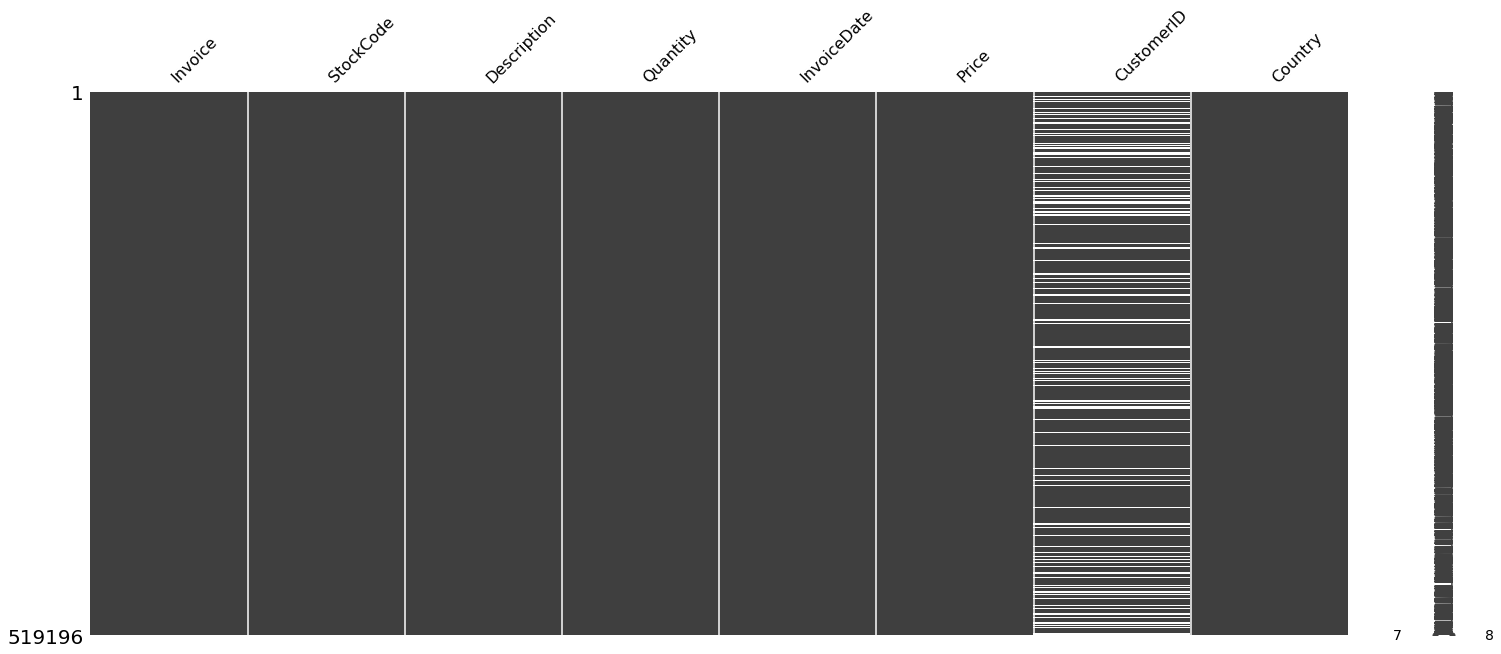

In [19]:
# See distribution of null values, looking for areas of concentration as possible signs of errors in data collection
msno.matrix(df);

The null ID records look fairly evenly distributed throuout the dataset, so there is no obvious malfunction that led to these missing fields (such as 'the customer ID wasn't being tracked for this 3-day period'). But, for the sake of thoroughness, we can check if there were any days with an especially high number of transactions missing IDs.

In [20]:
# Set datetime index to columns of interest
by_date = df.set_index(df.InvoiceDate)

# Add columns for date, and boolean of null or not null
by_date['date'] = by_date.index.date
by_date['null_id'] = by_date['CustomerID'].isnull()

# Aggregate total count and total null per date
null_by_date = by_date.groupby('date').agg({'null_id':['sum', 'count']})

# Calculate percentage of transactions per day that are null
null_by_date['pct'] = null_by_date['null_id']['sum'] / null_by_date['null_id']['count'] * 100

# Print findings
print("Percent null ID per day: \n", 
          null_by_date.pct.describe()[[1,3, 5,7]])
print("\nDays with greatest % null ID:\n", 
          null_by_date.sort_values('pct', ascending=False).pct.head())

Percent null ID per day: 
 mean    17.957312
min      0.000000
50%     16.206710
max     81.952507
Name: pct, dtype: float64

Days with greatest % null ID:
 date
2009-12-22    81.952507
2010-01-11    79.782037
2010-01-13    67.490729
2010-06-04    64.511389
2010-04-19    62.403599
Name: pct, dtype: float64


Although the average number of transactions per day with null Customer ID roughly matches the overall averages in the data (indicating mostly even distribution across all days), there are some days with very high numbers of null values, including Dec. 12 2009 at almost 82%. Records missing a description had a much lower median percent per day than mean, indicating that there were a few days with unusually high null values that brought the mean up -- also including 12-22-09. Further investigation might be made into what happened on that date and others on the list.

In [21]:
# df of only null ID records
no_id = df[df.CustomerID.isnull()==True]
no_id.describe()

,Quantity,Price,CustomerID
count,103203.000000,103203.000000,0.0
mean,2.822486,5.161048,NaN
std,13.257096,17.545828,NaN
min,-120.000000,0.100000,NaN
25%,1.000000,1.700000,NaN
50%,1.000000,3.360000,NaN
75%,2.000000,5.910000,NaN
max,1540.000000,5117.030000,NaN


In [22]:
#df of only non-null ID records
no_null = df[df.CustomerID.isnull()==False]
no_null.describe()

,Quantity,Price,CustomerID
count,415993.000000,415993.000000,415993.000000
mean,12.795698,3.075647,15365.928965
std,101.397028,5.713983,1678.217689
min,-9360.000000,0.001000,12346.000000
25%,2.000000,1.250000,13995.000000
50%,5.000000,1.950000,15311.000000
75%,12.000000,3.750000,16805.000000
max,19152.000000,1269.510000,18287.000000


In [23]:
# Cap price at $500 to limit extreme outliers
no_id_lower = no_id[no_id.Price < 500]
no_null_lower = no_null[no_null.Price < 500]

print(no_id_lower.describe())
no_null_lower.describe()

            Quantity          Price  CustomerID
count  103199.000000  103199.000000         0.0
mean        2.822576       5.087166         NaN
std        13.257344       5.672268         NaN
min      -120.000000       0.100000         NaN
25%         1.000000       1.700000         NaN
50%         1.000000       3.360000         NaN
75%         2.000000       5.910000         NaN
max      1540.000000     408.400000         NaN


,Quantity,Price,CustomerID
count,415989.000000,415989.000000,415989.000000
mean,12.795831,3.067436,15365.926873
std,101.397507,4.990517,1678.218843
min,-9360.000000,0.001000,12346.000000
25%,2.000000,1.250000,13995.000000
50%,5.000000,1.950000,15311.000000
75%,12.000000,3.750000,16805.000000
max,19152.000000,413.400000,18287.000000


In [24]:
# Cap Quantity at 1000 to limit extreme outliers
no_id_lower = no_id[no_id.Quantity < 1000]
no_null_lower = no_null[no_null.Quantity < 1000]

print(no_id_lower.describe())
no_null_lower.describe()

            Quantity          Price  CustomerID
count  103199.000000  103199.000000         0.0
mean        2.774533       5.161209         NaN
std        10.735776      17.546149         NaN
min      -120.000000       0.100000         NaN
25%         1.000000       1.700000         NaN
50%         1.000000       3.360000         NaN
75%         2.000000       5.910000         NaN
max       902.000000    5117.030000         NaN


,Quantity,Price,CustomerID
count,415781.000000,415781.000000,415781.000000
mean,11.290081,3.077021,15366.071304
std,46.384392,5.715106,1678.161021
min,-9360.000000,0.001000,12346.000000
25%,2.000000,1.250000,13995.000000
50%,5.000000,1.950000,15311.000000
75%,12.000000,3.750000,16805.000000
max,992.000000,1269.510000,18287.000000


In [25]:
# Look for countries that appear ONLY in null ID records
no_id_countries = no_id.Country.unique()
no_null_countries = no_null.Country.unique()
np.setdiff1d(no_id_countries, no_null_countries)

array(['Bermuda', 'Hong Kong', 'Lebanon'], dtype=object)

In [26]:
# Check number of combined invoices for those countries
df[(df.Country=='Bermuda')|(df.Country=='Hong Kong')|(df.Country=='Lebanon')].groupby(['Country', 'Invoice']).count()

StockCode  Description  Quantity  InvoiceDate  Price  \
Country   Invoice                                                         
Bermuda   501577          34           34        34           34     34   
Hong Kong 505214          48           48        48           48     48   
          513405          24           24        24           24     24   
Lebanon   522200          12           12        12           12     12   

                   CustomerID  
Country   Invoice              
Bermuda   501577            0  
Hong Kong 505214            0  
          513405            0  
Lebanon   522200            0

The records missing IDs have a higher average price (\~\\$5 vs. \~\\$3) and lower average quantity (~3 vs. ~13) than the other records, even after ignoring transactions with a price greater than $500 or quantity greater than 1000.

All records from Bermuda, Hong Kong, and Lebanon had null IDs (though this only includes 4 different invoices/orders).

Further analysis should be considered on this group of null IDs, if it is possible to determine the reason for the missing information, as there does seem to be a difference in behavior among this group.

Moving on, let's keep only non-null records and begin visualizing some patterns in the data.

In [27]:
df = no_null.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415993 entries, 0 to 415992
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      415993 non-null  object        
 1   StockCode    415993 non-null  object        
 2   Description  415993 non-null  object        
 3   Quantity     415993 non-null  int64         
 4   InvoiceDate  415993 non-null  datetime64[ns]
 5   Price        415993 non-null  float64       
 6   CustomerID   415993 non-null  float64       
 7   Country      415993 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 25.4+ MB
